In [1]:
from functions import *
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import cmapy

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Only GPU 1 is visible to this code


# in order to get reproducable results
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)
random.seed(1)

In [2]:
isval = False
seis_path = '/data/anyu/thebeData/processedThebe/test/oriseis/'
# fault_path = ''
if isval:
    seis_path = '/data/anyu/thebeData/processedThebe/sliceval/oriseis/'
#     fault_path = ''
print(seis_path)

/data/anyu/thebeData/processedThebe/test/oriseis/


Make input is IL, Z, XL order.

In [3]:
im_height = 1537
im_width = 3174
splitsize = 96
stepsize = 48 #overlap half
overlapsize = splitsize-stepsize

In [4]:
horizontal_splits_number = int(np.ceil((im_width)/stepsize))
print(horizontal_splits_number)
width_after_pad = stepsize*horizontal_splits_number+2*overlapsize
print(width_after_pad)
left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print(left_pad,right_pad)

vertical_splits_number = int(np.ceil((im_height)/stepsize))
print(vertical_splits_number)
height_after_pad = stepsize*vertical_splits_number+2*overlapsize
print(height_after_pad)
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print(top_pad,bottom_pad)

67
3312
69 69
33
1680
71 72


In [5]:
horizontal_splits_number = horizontal_splits_number+1
print(horizontal_splits_number)
vertical_splits_number = vertical_splits_number+1
print(vertical_splits_number)

68
34


In [6]:
halfoverlapsize = int(overlapsize/2)
print(halfoverlapsize)

24


In [7]:
t_start = time.time()
X_list = []
sectionNumber = 141
if isval:
    sectionNumber = 40
for i in range(0,sectionNumber,1): #len(seis)
    file_path = seis_path + "{}.npy".format(i)
    img = np.load(file_path)
    X_list.extend(split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number))
    
print(len(X_list))
print(X_list[0].shape)
print("read images in {} sec".format(time.time()-t_start))
X = np.asarray(X_list)
print(X.shape)
print("read images in {} sec".format(time.time()-t_start))


325992
(96, 96)
read images in 23.848592281341553 sec
(325992, 96, 96)
read images in 34.67517685890198 sec


In [8]:
X = X.astype(np.float32)
# X = np.expand_dims(X,1)
print(X.shape)

(325992, 96, 96)


In [9]:
modelname = "deeplabv3_resnet101_thebe_3_10_0.001_imagenetft_SDN_v2_100_20"
if "deeplabv3_resnet101" in modelname: 
    from torchvision import models
    if "cocoft" in modelname:
        print("coco")
        model = models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=21,aux_loss=True, pretrained_backbone=False)
        num_ftrs = model.classifier[4].in_channels
        model.classifier[4] = nn.Conv2d(num_ftrs, 1, kernel_size=(1, 1), stride=(1, 1))
#         print(model)
    else:
        print("other")
        model = models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=1,aux_loss=False, pretrained_backbone=False)
#     model = models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=1,aux_loss=True)
    print("use torchvision deeplabv3_resnet101")
elif "resnet101" in modelname: 
    from torchvision import models
    model = models.segmentation.fcn_resnet101(pretrained=False, num_classes=1,aux_loss=True)
    print("use torchvision resnet101")   
elif "unet" in modelname: 
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
elif "deeplab" in modelname: 
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
elif "hed" in modelname: 
    from model_zoo.HED import HED
    model = HED()
    print("use model HED") 
elif "rcf" in modelname: 
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
else:
    print("please enter a valid model")
    
best_model_fpath = './' + modelname #+ ".model"
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0")) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)
save_path = './overlap_clean_predictions/{}_smooth'.format(modelname)
if isval:
    save_path = save_path + "_val"
print(save_path)

other
use torchvision deeplabv3_resnet101
./overlap_clean_predictions/deeplabv3_resnet101_thebe_3_10_0.001_imagenetft_SDN_v2_100_20_smooth


In [10]:
import torch.utils.data
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, name):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """

        self.images = preprocessed_images
        self.name = name


    def __len__(self):
        return len(self.images)
    
    def transform(self, img):
        # to tensor
        img = TF.to_tensor(img)  
        
        # scale to (0,1) dataset wise, using dataset min, max
        if "_clip" in self.name:
            if "_clipEO" in self.name: 
#                 print("in clip eo")
                img = np.clip(img, -0.1924, 0.1939) # to change
                img = (img+0.1924)/(0.1939+0.1924)
            else:
#                 print("in clip")
                img = np.clip(img, -0.1111, 0.1096) # to change
                img = (img+0.1111)/(0.1096+0.1111)
        else:
            img = (img+8.3939)/(9.4332+8.3939)
        
        # normalize based on dataset mean std
        if "_DN" in self.name:
            if "_clip" in self.name:
                if "_clipEO" in self.name:  
#                     print("clip eo dn")
                    img = TF.normalize(img, [0.4986,], [0.2230,])
                else:
#                     print("clip dn")
                    img = TF.normalize(img, [0.4985,], [0.2855,]) # to change
            else:
#                 print("dn")
                img = TF.normalize(img, [0.4708,], [0.0079,])
        
#         print(img.shape)
        if "resnet101" in modelname: 
            imgrgb = torch.zeros(3,96,96).type(torch.cuda.FloatTensor)
            imgrgb[0] = img
            imgrgb[1] = img
            imgrgb[2] = img
        else:
            imgrgb = img
            
        if "_SDN" in self.name:
            if "cocoft" in self.name:
                imgrgb = TF.normalize(imgrgb, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            elif "imagenet" in self.name:
                imgrgb = TF.normalize(imgrgb, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            elif "faultSegft" in self.name:
                if "resnet101" in modelname: 
                    imgrgb = TF.normalize(imgrgb, [0.5005, 0.5005, 0.5005], [0.1205, 0.1205, 0.1205])
                else:
                    imgrgb = TF.normalize(imgrgb, [0.5005,], [0.1205,])
            elif "bsdsft" in self.name:
                if "resnet101" in modelname: 
                    imgrgb = TF.normalize(imgrgb, [0.4256, 0.4256, 0.4256], [0.2327, 0.2327, 0.2327])
                else:
                    imgrgb = TF.normalize(imgrgb, [0.4256,], [0.2327,])  
            else:
                print("please enter a valid source dataset set")
            
        return imgrgb
    

    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        return image




In [11]:
faults_dataset_test = faultsDataset(X, modelname)

batch_size = 32

test_loader = torch.utils.data.DataLoader(dataset=faults_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [15]:
UPPER_BOUND = 800
LOWER_BOUND = 1300
print("UPPER_BOUND",UPPER_BOUND)
print("LOWER_BOUND",LOWER_BOUND)
    
def saveResults(save_path, test_loader):     
    os.makedirs(save_path, exist_ok=True)

    test_predictions = []
    imageNo = -1
    model.eval()
    for images in test_loader:
#         images = Variable(images.double().to(device=device))
        images = Variable(images.to(device=device, dtype=torch.float))
                 
        outputs = model(images)
        y_preds = outputs
        if "hed" in modelname: 
            y_preds = outputs[-1]
        elif "rcf" in modelname: 
            y_preds = outputs[-1]
        elif "resnet101" in modelname: 
            classfer_outputs = outputs["out"]
            y_preds = torch.sigmoid(classfer_outputs)
#             outputs = model(images)["out"]
#             y_preds = torch.sigmoid(outputs)
            
            
        test_predictions.extend(y_preds.detach().cpu())
        if len(test_predictions)>=vertical_splits_number*horizontal_splits_number:
            imageNo = imageNo +1
            tosave = torch.stack(test_predictions).detach().cpu().numpy()[0:vertical_splits_number*horizontal_splits_number]
            test_predictions = test_predictions[vertical_splits_number*horizontal_splits_number:]

            WINDOW_SPLINE_2D = window_2D(window_size=splitsize, power=2)
            tosave = np.moveaxis(tosave,-3,-1)
            tosave = np.array([patch * WINDOW_SPLINE_2D for patch in tosave])
            tosave = tosave.reshape((vertical_splits_number, horizontal_splits_number, splitsize,splitsize,1))
            recover_Y_test_pred = recover_Image2(tosave, (im_height,im_width,1), left_pad,right_pad,top_pad,bottom_pad,overlapsize)
            os.makedirs(save_path, exist_ok=True)
            np.save(os.path.join(save_path,"{}".format(imageNo)),np.squeeze(recover_Y_test_pred)[UPPER_BOUND:LOWER_BOUND,:])   
            print(imageNo)
                        

print("save")
t1 = time.time()
saveResults(save_path, test_loader)
t2 = time.time()
print('save in {} sec'.format(t2-t1))

UPPER_BOUND 800
LOWER_BOUND 1300
save
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
save in 1874.9254603385925 sec


In [16]:
print(save_path)

./overlap_clean_predictions/deeplabv3_resnet101_thebe_3_10_0.001_imagenetft_SDN_v2_100_20_smooth


In [17]:
a = np.load(save_path + "/0.npy")

In [18]:
print(a.dtype, a.max(), a.min())

float64 0.9982968594525197 1.1935444372942913e-05


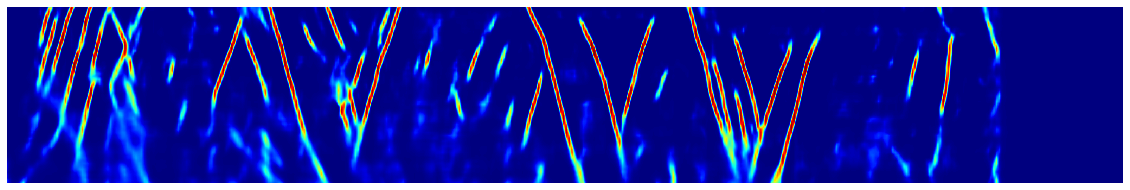

In [19]:
heatmap_img = cv2.applyColorMap((a*255).astype(np.uint8), cmapy.cmap('jet_r'))
plt.figure(figsize=(20,16))
plt.imshow(heatmap_img)
# plt.colorbar(shrink=0.5)
plt.axis('off')
plt.show()